<a href="https://colab.research.google.com/github/Khlebovich-Alexandra/horoscope_generator/blob/master/text_generation_symbols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text generation with an RNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM 
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import itertools
import os
import re
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
posts = pd.read_csv('https://raw.githubusercontent.com/Khlebovich-Alexandra/horoscope_generator/master/Data/final_posts.csv', index_col=0)

In [0]:
text = posts.text
text = '\n'.join(text)

print ('Length of text: {} characters'.format(len(text)))

Length of text: 8121558 characters


In [0]:
# Take a look at the first 250 characters in text
print(text[:250])

сегодня вы можете почувствовать незащищенность и неуверенность в собственных силах. попробуйте проанализировать ситуацию и выяснить, что же так сильно выбило вас из колеи. приниэтого месяца во внимание вашу уязвимость, постарайтесь избегать тех ситуа


In [0]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

86 unique characters


In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)


In [0]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text


In [0]:
dataset = sequences.map(split_input_target)

In [0]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 100), (128, 100)), types: (tf.int64, tf.int64)>

In [0]:
def buid_model(batch):
    vocab_size = len(vocab)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 256,
                                batch_input_shape=[batch, None]),
        tf.keras.layers.LSTM(units=1024,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [0]:
model = buid_model(BATCH_SIZE)
model.load_weights('drive/My Drive/Colab Notebooks/weights_70.h5')
model.build(tf.TensorShape([BATCH_SIZE, None]))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (128, None, 256)          22016     
_________________________________________________________________
lstm_4 (LSTM)                (128, None, 1024)         5246976   
_________________________________________________________________
dense_4 (Dense)              (128, None, 86)           88150     
Total params: 5,357,142
Trainable params: 5,357,142
Non-trainable params: 0
_________________________________________________________________
None


## Train the model

In [0]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [0]:
model.compile(optimizer='adam', loss=loss)

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback_2=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix+'_symb',
    period=10,
    save_weights_only=True,
    verbose=0)
checkpoint_callback_3=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix+'_symb',
    save_weights_only=True,
    verbose=0)

In [0]:
EPOCH = 10
history1 = model.fit(dataset,
                     epochs=EPOCH,
                     callbacks=[checkpoint_callback_3])

Train for 628 steps
Epoch 1/10
628/628 [==============================] - 55s 87ms/step - loss: 0.7023
Epoch 2/10
628/628 [==============================] - 54s 86ms/step - loss: 0.7016
Epoch 3/10
628/628 [==============================] - 54s 85ms/step - loss: 0.7013
Epoch 4/10
628/628 [==============================] - 54s 86ms/step - loss: 0.7013
Epoch 5/10
628/628 [==============================] - 54s 86ms/step - loss: 0.7009
Epoch 6/10
628/628 [==============================] - 54s 85ms/step - loss: 0.7002
Epoch 7/10
628/628 [==============================] - 54s 86ms/step - loss: 0.7006
Epoch 8/10
628/628 [==============================] - 54s 85ms/step - loss: 0.7001
Epoch 9/10
628/628 [==============================] - 53s 85ms/step - loss: 0.6996
Epoch 10/10
628/628 [==============================] - 53s 85ms/step - loss: 0.7000


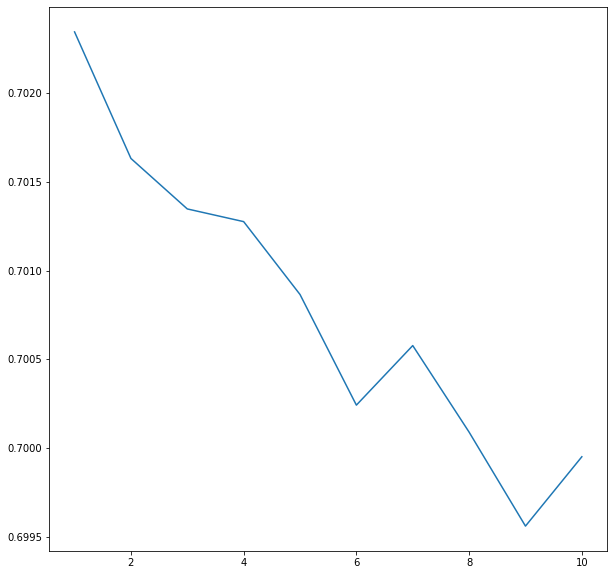

In [0]:
plt.figure(figsize=(10, 10))
x = list(range(1, EPOCH+1))
plt.plot(x, history1.history.get('loss'))

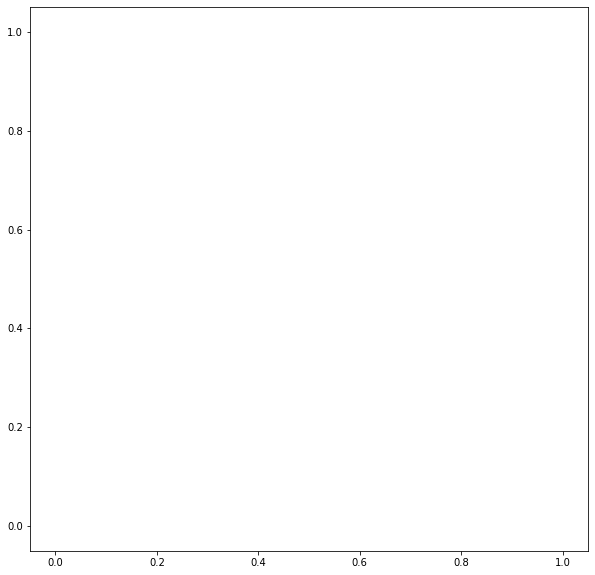

In [0]:
plt.figure(figsize=(10, 10))
x = list(range(1, EPOCH+1))
plt.plot(x[10:], history1.history.get('loss')[10:])

In [0]:
model.save_weights('drive/My Drive/Colab Notebooks/weights_80.h5')

## Generate text

In [0]:
model = buid_model(1)
model.load_weights('drive/My Drive/Colab Notebooks/weights_80.h5')
model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 256)            22016     
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_5 (Dense)              (1, None, 86)             88150     
Total params: 5,357,142
Trainable params: 5,357,142
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_n_symbols(model, start_string, num_generate):
  # Evaluation step (generating text using the learned model)

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [0]:
%%time
generated = generate_n_symbols(model, 'сегодня', 500000)
fileObject = open('drive/My Drive/Colab Notebooks/generate_80.txt', 'w', encoding='utf-8')
fileObject.write(generated)

CPU times: user 32min 56s, sys: 1min 15s, total: 34min 12s
Wall time: 31min 27s


In [0]:
%%time
generated = generate_n_symbols(model, 'сегодня', 500000)
fileObject = open('drive/My Drive/Colab Notebooks/generate_80_1.txt', 'w', encoding='utf-8')
fileObject.write(generated)

CPU times: user 33min 16s, sys: 1min 13s, total: 34min 30s
Wall time: 31min 44s


In [0]:
%%time
generated = generate_n_symbols(model, 'сегодня', 500000)
fileObject = open('drive/My Drive/Colab Notebooks/generate_80_2.txt', 'w', encoding='utf-8')
fileObject.write(generated)

CPU times: user 33min 24s, sys: 1min 14s, total: 34min 39s
Wall time: 31min 53s


In [0]:
%%time
generated = generate_n_symbols(model, 'сегодня', 500000)
fileObject = open('drive/My Drive/Colab Notebooks/generate_70.txt', 'w', encoding='utf-8')
fileObject.write(generated)

CPU times: user 33min 28s, sys: 1min 15s, total: 34min 44s
Wall time: 31min 57s


In [0]:
model.save_weights('drive/My Drive/Colab Notebooks/weights_70.h5')

In [0]:
%%time
generated = generate_n_symbols(model, 'сегодня', 500000)
fileObject = open('drive/My Drive/Colab Notebooks/generate_70_1.txt', 'w', encoding='utf-8')
fileObject.write(generated)

CPU times: user 33min 32s, sys: 1min 16s, total: 34min 48s
Wall time: 32min
